In [1]:
import time
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim

import DRLPDE_nn
import DRLPDE_functions.EvaluateWalkers
import DRLPDE_param_solver
 
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300




In [2]:
mu = 1

# Physical Dimension
x_dim = 2
output_dim = 2

# Neural Network Architecture
nn_depth = 60
nn_width = 4

periodic1 = { 'variable':'x', 
              'base':-math.pi,
              'top':math.pi }

periodic2 = { 'variable':'y', 
              'base':-math.pi,
              'top':math.pi }

list_of_periodic_boundaries =[periodic1, periodic2]

class bdry_periodic:

    def __init__(self, variable, base, top):
        
        if variable == 'x':
            self.index = 0
        if variable == 'y':
            self.index = 1
        if variable == 'z':
            self.index = 2

        self.base = base
        self.top = top

my_periodic_boundaries = []
for specs in list_of_periodic_boundaries:
    my_periodic_boundaries.append( bdry_periodic( variable = specs['variable'],
                                                    base = specs['base'],
                                                    top = specs['top']  ))


In [3]:
nn_param = {'depth': nn_depth,
            'width': nn_width,
            'x_dim': x_dim,
            'is_unsteady': True ,
            'output_dim': output_dim
            }

vel_nn_param = {'depth': 60,
            'width': 4,
            'x_dim': 2,
            'is_unsteady': True ,
            'output_dim': 2
            }

In [4]:
class FeedForwardNN(nn.Module):
    
    ### Feed forward neural network
    
    def __init__(self, depth, width, x_dim, is_unsteady, output_dim, **nn_param):
        super(FeedForwardNN, self).__init__()
        
        self.input_dim = x_dim + is_unsteady
        
        modules = []
        modules.append(nn.Linear(self.input_dim, depth))
        for i in range(width - 1):
            modules.append(nn.Linear(depth, depth))
            modules.append(nn.ELU())
        modules.append(nn.Linear(depth, 1))
        
        self.sequential_model = nn.Sequential(*modules)
        
    def forward(self, x):
        a = self.sequential_model(x)
        
        return a


def eval_gradient(X, model):
    X.requires_grad = True
    a = model(X)

    grad_model = torch.autograd.grad(a, X, grad_outputs = torch.ones_like(a), create_graph = True, 
                                       retain_graph = True, only_inputs = True)[0]

    return grad_model[:,:x_dim]

In [5]:
def true_pressure(x):
    p_0 = -1/2 *torch.exp(-4*mu*x[:,2])
    p = -1/4 * (torch.cos(2*x[:,0]) + torch.cos(2*x[:,1]))*torch.exp(-4*mu*x[:,2]) - p_0

    return p

def shifted_pressure(x):
    ### zero at point (0,0)

    x0 = torch.cat( ( torch.zeros_like(x[:,:-1]), x[:,-1,None] ), dim=1)

    p = true_pressure(x) - true_pressure(x0)

    return p

def true_solution(X):
    u = torch.stack( ( torch.cos(X[:,0])*torch.sin(X[:,1])*torch.exp(-2*mu*X[:,2]),
                       -torch.sin(X[:,0])*torch.cos(X[:,1])*torch.exp(-2*mu*X[:,2]) ), dim=1)
    return u

def true_pressure_gradient(x):

    p1 = -1/2 * (torch.sin(2*x[:,0]))*torch.exp(-4*mu*x[:,2])
    p2 = -1/2 * (torch.sin(2*x[:,1]))*torch.exp(-4*mu*x[:,2])

    return torch.stack((p1,p2), dim=1)


In [6]:
model_velocity = DRLPDE_nn.IncompressibleNN(**vel_nn_param)
model_velocity.load_state_dict(torch.load("savedmodels/TaylorGreen.pt"))
model_velocity.to('cpu').eval()

model_pressure = FeedForwardNN(**nn_param)
model_pressure.load_state_dict(torch.load("savedmodels/pressureTaylorGreen.pt"))
model_pressure.to('cpu').eval()

FeedForwardNN(
  (sequential_model): Sequential(
    (0): Linear(in_features=3, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=60, bias=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=60, out_features=60, bias=True)
    (4): ELU(alpha=1.0)
    (5): Linear(in_features=60, out_features=60, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [7]:
####################### Plotting and Error Parameters ########################
numpts_x = 64
numpts_y =  64

xg = torch.cat( (torch.cartesian_prod(torch.linspace(-math.pi,math.pi,numpts_x),
                                         torch.linspace(-math.pi,math.pi,numpts_y)), 
                    torch.zeros((numpts_x*numpts_y,1))), dim=1).requires_grad_(True)

#x1g, x2g = torch.meshgrid( (torch.linspace(-math.pi,math.pi,numpts_x),torch.linspace(-math.pi,math.pi,numpts_y)))
#xg = torch.stack( (x1g.reshape(-1), x2g.reshape(-1), torch.zeros((numpts_x*numpts_y))), dim=1).requires_grad_(True)


In [8]:

dt = 1e-2
num_ghost = 512
tol = 1e-6

def periodic_condition(Xnew, periodic_boundaries):
    for bdry in periodic_boundaries:
        below_base = Xnew[:,bdry.index] < bdry.base
        above_top = Xnew[:,bdry.index] > bdry.top

        if torch.sum(below_base) > 0:
            Xnew[below_base, bdry.index] = Xnew[below_base, bdry.index] + (bdry.top - bdry.base)
        if torch.sum(above_top) > 0:
            Xnew[above_top,bdry.index] = Xnew[above_top, bdry.index] - (bdry.top - bdry.base)
    return Xnew

def find_time_exit(Xold, Xnew, tol):
    ### Bisection algorithm to find the time exit up to a tolerance
    
    Xmid = (Xnew + Xold)/2

    # above tolerance = inside
    # below tolerance = outside
    above_tol = Xmid[:,-1] > tol
    below_tol = Xmid[:,-1] < -tol

    if torch.sum(above_tol + below_tol) > 0:
        Xnew[below_tol,:] = Xmid[below_tol,:]
        Xold[above_tol,:] = Xmid[above_tol,:]
        
        Xmid[above_tol + below_tol,:] = find_time_exit(Xold[above_tol + below_tol,:], Xnew[above_tol + below_tol,:], tol)

    return Xmid
    

def make_target(Xold):

    numpts = Xold.size(0)

    ### Generate points -- requires grad

    ### Move Walkers
    Uold = model_velocity(Xold)
    #Uold = true_solution(Xold)

    Zt = np.sqrt(dt)*torch.randn((numpts*num_ghost, x_dim))

    Xnew = Xold.detach().repeat(num_ghost,1)  + torch.cat( (-dt*Uold.detach().repeat(num_ghost,1) + np.sqrt(2*mu)*Zt, 
                                                            -dt*torch.ones((numpts*num_ghost,1))), dim=1)


    ### Initial condition
    hit_initial = Xnew[:,-1] < 0
    Xnew[hit_initial,:] = find_time_exit(Xold.repeat(num_ghost,1)[hit_initial,:], Xnew[hit_initial,:], tol)

    ### Calculate periodic boundaries
    Xnew = periodic_condition(Xnew, my_periodic_boundaries)

    #Xnew.requires_grad=True
    Unew = model_velocity(Xnew).reshape(num_ghost, numpts, output_dim).mean(0)
    #Unew = true_solution(Xnew).reshape(num_ghost, numpts, output_dim).mean(0)

    ###
    target = (Unew - Uold).detach()/dt

    return target


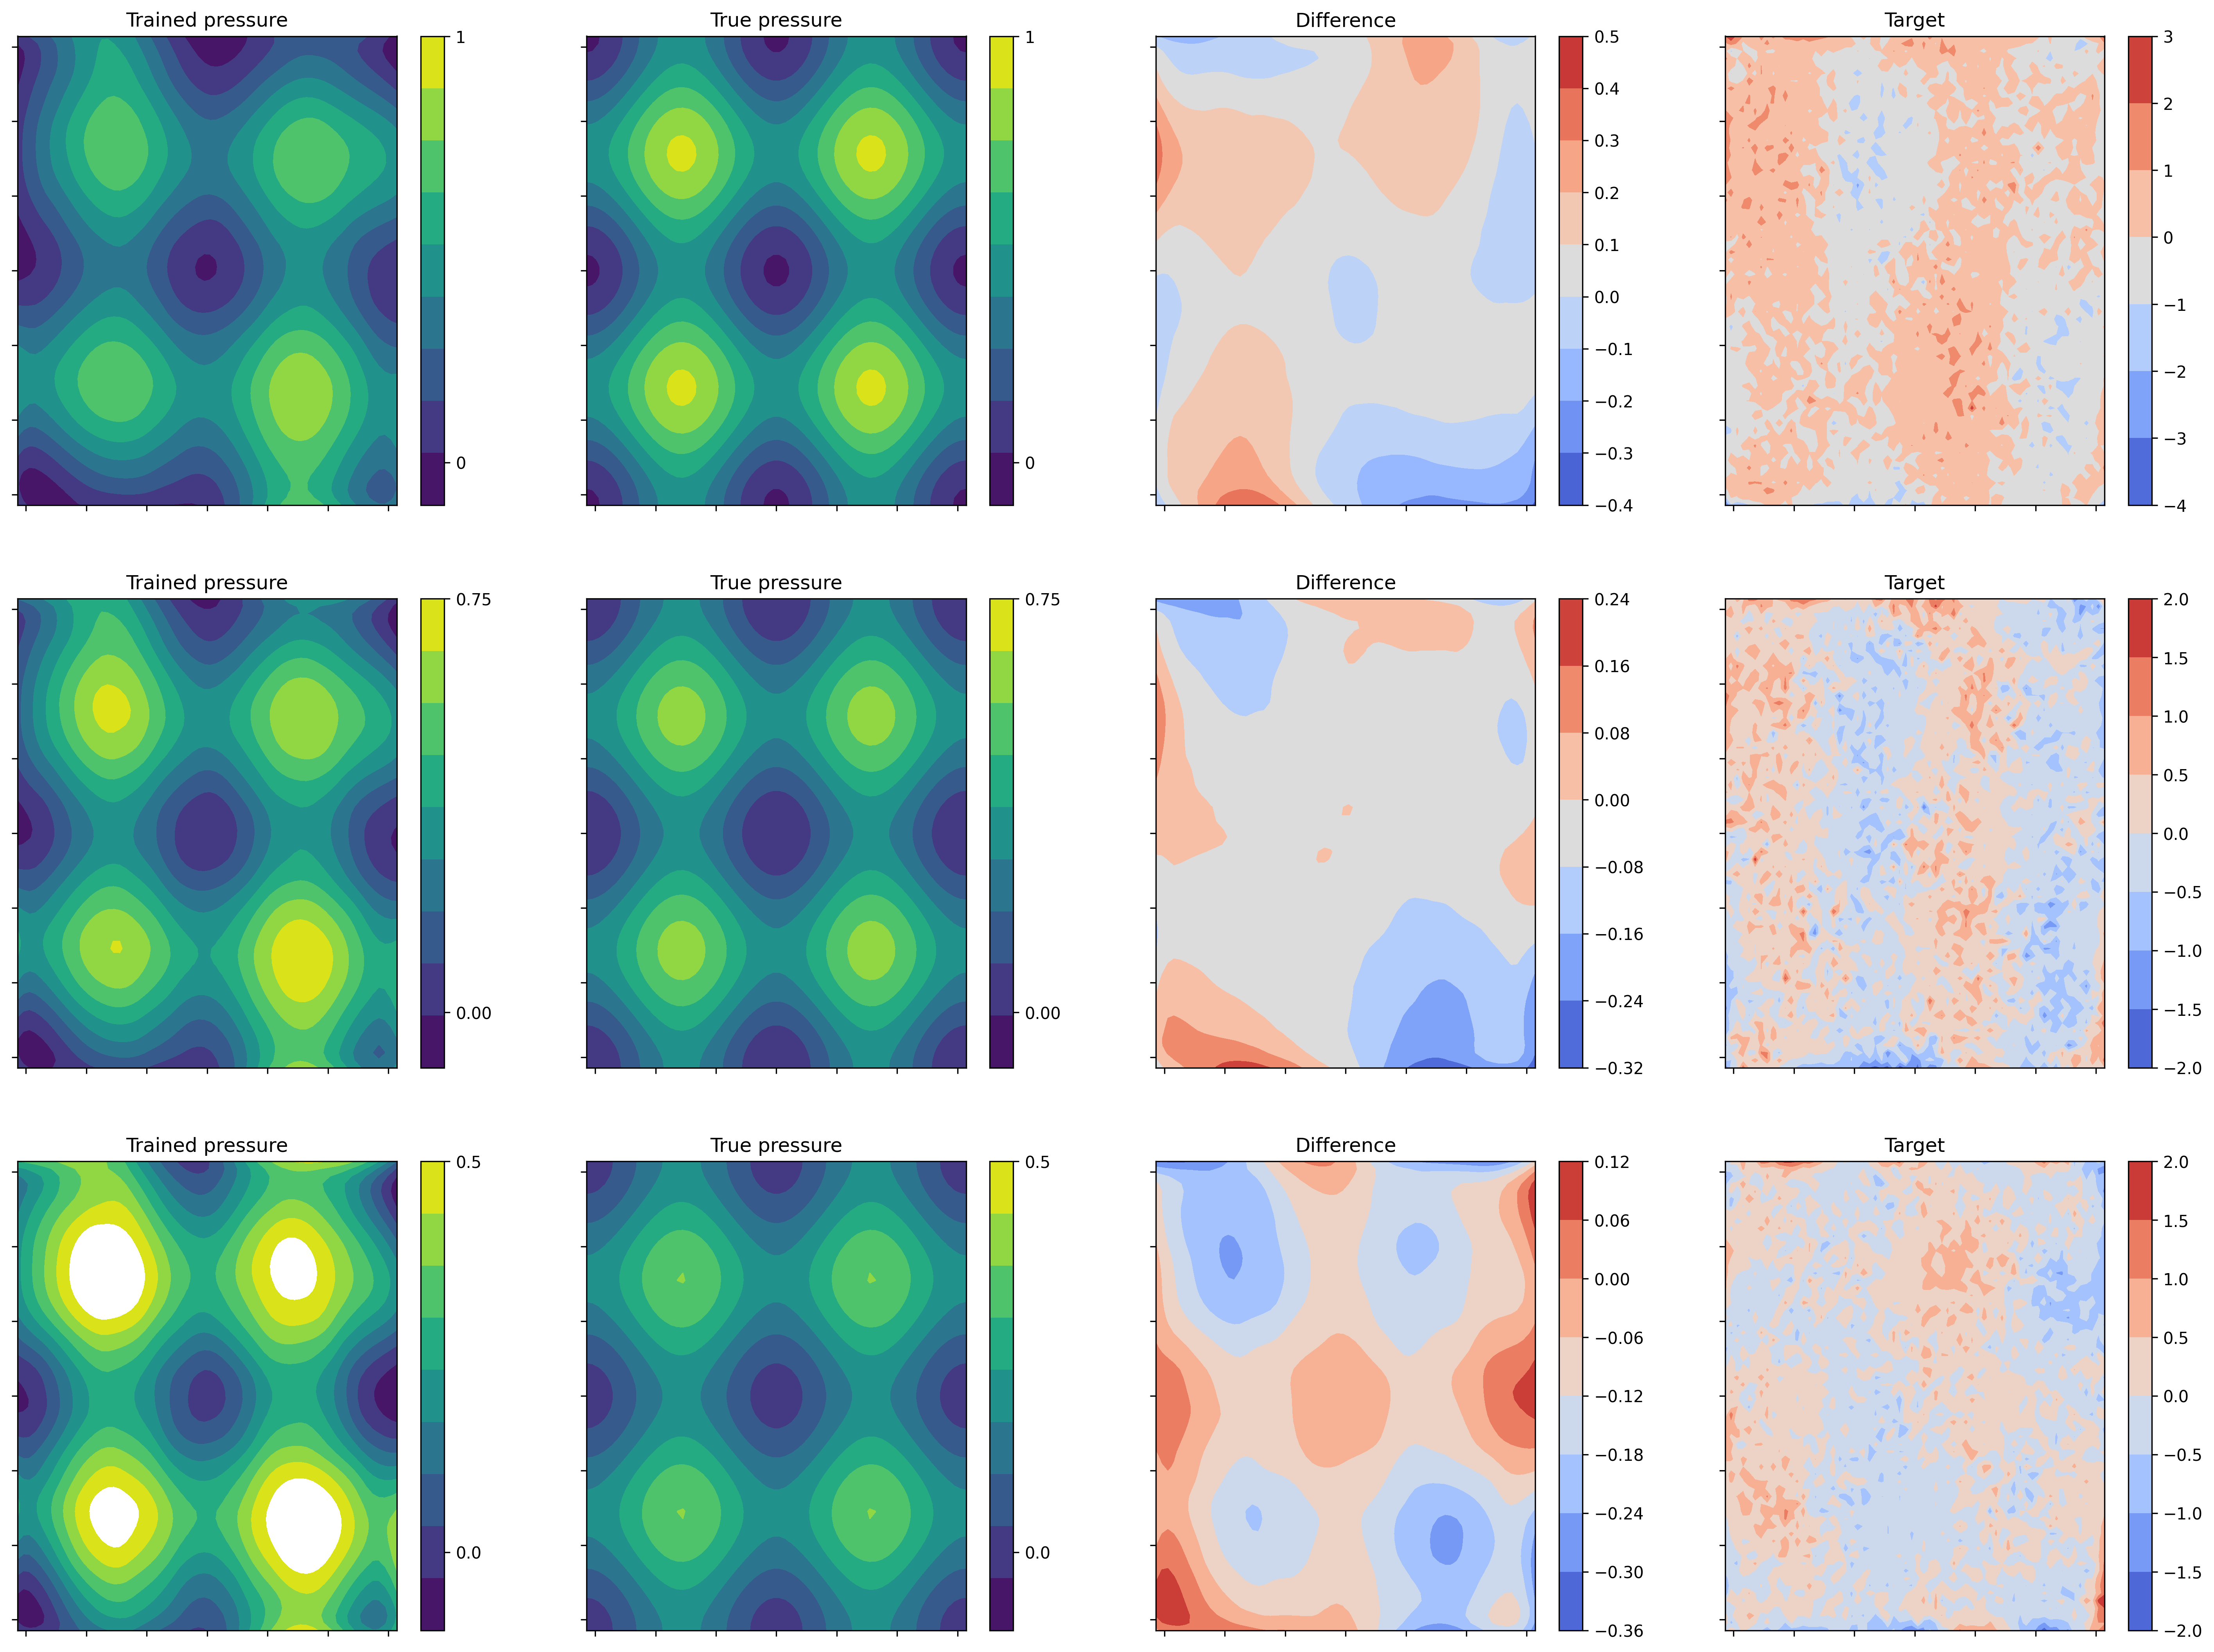

In [9]:
plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=[24, 18])

xplot = xg[:,0].reshape(numpts_x, numpts_y).detach().numpy()
yplot = xg[:,1].reshape(numpts_x, numpts_y).detach().numpy()

levels_flow_1 = np.linspace(-0.1, 1.0, 10)
levels_flow_2 = np.linspace(-0.1, 0.75, 10)
levels_flow_3 = np.linspace(-0.1, 0.5, 10)

levels_tick_1 = [ 0, levels_flow_1[-1]]
levels_tick_2 = [ 0, levels_flow_2[-1]]
levels_tick_3 = [ 0, levels_flow_3[-1]]

### Different Times

# t = 0.025

xg.requires_grad=False
xg[:,2] = 0.025
xg.requires_grad=True

Trained_P = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

True_P = shifted_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

target = make_target(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()

contour0 = ax[0,0].contourf(xplot, yplot, Trained_P, levels_flow_1 , cmap=plt.cm.viridis)
ax[0,0].set_title(r'Trained pressure')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
plt.colorbar(contour0, ticks=levels_tick_1, ax=ax[0,0])

contour1 = ax[0,1].contourf(xplot, yplot, True_P, levels_flow_1 , cmap=plt.cm.viridis)
ax[0,1].set_title(r'True pressure')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
plt.colorbar(contour1, ticks=levels_tick_1, ax=ax[0,1])

contour2 = ax[0,2].contourf(xplot, yplot, True_P - Trained_P, cmap=plt.cm.coolwarm)
ax[0,2].set_title(r'Difference')
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
plt.colorbar(contour2, ax=ax[0,2])

contour21 = ax[0,3].contourf(xplot, yplot, target[:,:,0], cmap=plt.cm.coolwarm)
ax[0,3].set_title(r'Target')
ax[0,3].set_xticklabels([])
ax[0,3].set_yticklabels([])
plt.colorbar(contour21, ax=ax[0,3])

# t = 0.125

xg.requires_grad=False
xg[:,2] = 0.125
xg.requires_grad=True

Trained_P = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

True_P = shifted_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

target = make_target(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()

contour3 = ax[1,0].contourf(xplot, yplot, Trained_P, levels_flow_2, cmap=plt.cm.viridis)
ax[1,0].set_title(r'Trained pressure')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
plt.colorbar(contour3, ticks=levels_tick_2, ax=ax[1,0])

contour4 = ax[1,1].contourf(xplot, yplot, True_P, levels_flow_2, cmap=plt.cm.viridis)
ax[1,1].set_title(r'True pressure')
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
plt.colorbar(contour4, ticks=levels_tick_2, ax=ax[1,1])

contour5 = ax[1,2].contourf(xplot, yplot, True_P - Trained_P, cmap=plt.cm.coolwarm)
ax[1,2].set_title(r'Difference')
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
plt.colorbar(contour5, ax=ax[1,2])

contour51 = ax[1,3].contourf(xplot, yplot, target[:,:,0], cmap=plt.cm.coolwarm)
ax[1,3].set_title(r'Target')
ax[1,3].set_xticklabels([])
ax[1,3].set_yticklabels([])
plt.colorbar(contour51, ax=ax[1,3])

# t = 0.25

xg.requires_grad=False
xg[:,2] = 0.25
xg.requires_grad=True

Trained_P = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

True_P = shifted_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

target = make_target(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()

contour6 = ax[2,0].contourf(xplot, yplot, Trained_P, levels_flow_3, cmap=plt.cm.viridis)
ax[2,0].set_title(r'Trained pressure')
ax[2,0].set_xticklabels([])
ax[2,0].set_yticklabels([])
plt.colorbar(contour6, ticks=levels_tick_3, ax=ax[2,0])

contour7 = ax[2,1].contourf(xplot, yplot, True_P, levels_flow_3, cmap=plt.cm.viridis)
ax[2,1].set_title(r'True pressure')
ax[2,1].set_xticklabels([])
ax[2,1].set_yticklabels([])
plt.colorbar(contour7, ticks=levels_tick_3, ax=ax[2,1])

contour8 = ax[2,2].contourf(xplot, yplot, True_P - Trained_P, cmap=plt.cm.coolwarm)
ax[2,2].set_title(r'Difference')
ax[2,2].set_xticklabels([])
ax[2,2].set_yticklabels([])
plt.colorbar(contour8, ax=ax[2,2])

contour81 = ax[2,3].contourf(xplot, yplot, target[:,:,0], cmap=plt.cm.coolwarm)
ax[2,3].set_title(r'Target')
ax[2,3].set_xticklabels([])
ax[2,3].set_yticklabels([])
plt.colorbar(contour81, ax=ax[2,3])

In [10]:
### Error Calculation

numpts_x = 128
numpts_y =  128
numpts_time = 50
dt = 0.25/numpts_time

xg = torch.cat( ( torch.torch.cartesian_prod( torch.linspace(-math.pi,math.pi,numpts_x),
                                              torch.linspace(-math.pi,math.pi,numpts_y)),
                   torch.zeros((numpts_x*numpts_y,1))), dim=1).requires_grad_(True)

integral_factor =  dt*(4*math.pi**2)/(numpts_x - 1)/(numpts_y-1)



L2_error = 0
Linf_error = 0
L2_norm_true = 0

for tt in range(numpts_time):
    xg.requires_grad=False
    xg[:,2] = tt*dt
    xg.requires_grad=True

    Trained_P = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

    True_P = true_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

    L2_error +=  np.sum( (Trained_P - True_P)**2 )*integral_factor

    Linf_error = np.max( [np.max(np.abs(Trained_P - True_P)), Linf_error])

    L2_norm_true += np.sum( True_P**2)*integral_factor

L2_error = np.sqrt(L2_error)
L2_norm_true = np.sqrt(L2_norm_true)

print('L2 error = {:.4f}'.format(L2_error))
print('Linf error = {:.4f}'.format(Linf_error))
print('L2 Relative error = {:.4f}'.format(L2_error/L2_norm_true))
print('L2 norm true = {:.4f}'.format(L2_norm_true))


L2 error = 0.3074
Linf error = 0.4634
L2 Relative error = 0.2629
L2 norm true = 1.1691
